In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

## Helper functions

In [2]:
def load_dataset(name: str) -> pd.DataFrame:
    df = pd.read_csv(f'dataset/{name}_train.csv')
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    df['edge'] = df['client'] + '-' + df['server']
    df.index = df['timestamp']
    df.sort_index(inplace=True)
    return df

def plot_edges(df:pd.DataFrame):
    import matplotlib.pyplot as plt
    import networkx as nx

    # Create an empty directed graph
    G = nx.DiGraph()

    for edge in df['edge'].unique():
        [client, server] = edge.split('-')
        G.add_edge(client, server)

    # Draw the graph using Matplotlib's pyplot
    nx.draw(G, with_labels=True)
    plt.show()

def filter_interval(df: pd.DataFrame, start_date = None, minutes = 60):
    if start_date is None:
        start_date = df['timestamp'].min()
    end_date = start_date + pd.Timedelta(minutes=minutes)
    return df.loc[df['timestamp'].between(start_date, end_date)]

def group_by_timestamp(df: pd.DataFrame) -> list[dict]:
    result = []

    counter = 0
    
    tmp_ts = []
    tmp_values = []

    for _, row in df.iterrows():
        ts = row['timestamp']
        value = row['bitrate']
        tmp_ts.append(ts)
        tmp_values.append(value)
        if counter == 15:
            result.append({
                'timestamp': np.array(tmp_ts).min(),
                'values': np.array(tmp_values)
            })
            # reset counter
            counter = 0
            tmp_ts = []
            tmp_values = []
        counter +=1
    return result


def with_subplot(by: list[str], figsize = (20,25), title=''):
    '''Decorator to help create subplots'''
    def decorator(plot_func):
        def wrapper():
            groups = by
            width = 3
            height = math.ceil(len(groups) / width)
            figure, axis = plt.subplots(width, height, figsize=figsize)
            figure.suptitle(title)
            row_idx = 0
            col_idx = 0
            for group in groups:
                ax = axis[row_idx, col_idx]
                plot_func(ax, group)
                if col_idx == width -1:
                    row_idx +=1
                    col_idx = 0
                else:
                    col_idx +=1
        
            plt.show()
        return wrapper
    return decorator




## Data Exploration

In [3]:
bitrate = load_dataset('bitrate')
rtt = load_dataset('rtt')

In [4]:
bitrate.head()

,client,server,timestamp,bitrate,edge
timestamp,,,,,
2024-06-07 00:02:35,ba,df,2024-06-07 00:02:35,3000,ba-df
2024-06-07 00:02:36,rj,df,2024-06-07 00:02:36,323984,rj-df
2024-06-07 00:02:36,ba,df,2024-06-07 00:02:36,347367,ba-df
2024-06-07 00:02:36,ba,df,2024-06-07 00:02:36,327273,ba-df
2024-06-07 00:02:36,ba,df,2024-06-07 00:02:36,413041,ba-df


In [5]:
bitrate.describe()

,timestamp,bitrate
count,159030,159030.000000
mean,2024-06-09 07:34:07.095221248,320651.513991
min,2024-06-07 00:02:35,270.000000
25%,2024-06-08 03:38:36,300583.000000
50%,2024-06-09 07:14:06,354960.000000
75%,2024-06-10 10:52:37,401571.000000
max,2024-06-12 17:23:37,638686.000000
std,NaN,134394.514009


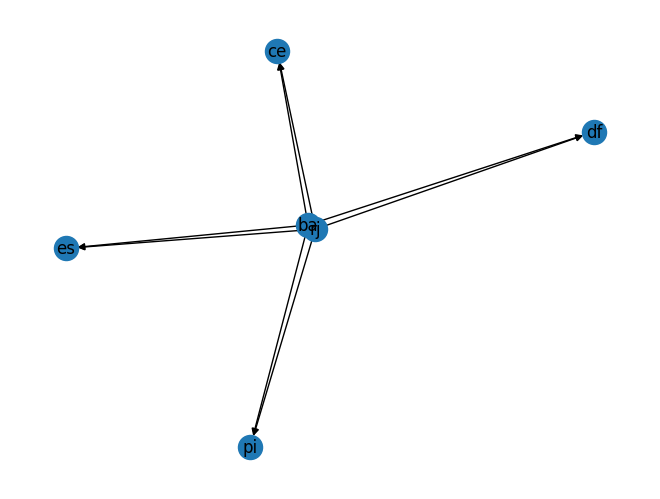

In [6]:
plot_edges(bitrate)

In [7]:
rtt.head()

,client,server,timestamp,rtt,edge
timestamp,,,,,
2024-06-07 00:02:37,rj,df,2024-06-07 00:02:37,21.440,rj-df
2024-06-07 00:02:47,rj,df,2024-06-07 00:02:47,21.360,rj-df
2024-06-07 00:04:07,ba,es,2024-06-07 00:04:07,12.620,ba-es
2024-06-07 00:04:34,rj,es,2024-06-07 00:04:34,7.023,rj-es
2024-06-07 00:05:11,rj,pi,2024-06-07 00:05:11,42.070,rj-pi


In [8]:
rtt.describe()

,timestamp,rtt
count,10901,10901.000000
mean,2024-06-09 13:14:05.852857344,22.592836
min,2024-06-07 00:02:37,6.879000
25%,2024-06-08 04:29:39,12.510000
50%,2024-06-09 12:43:27,19.530000
75%,2024-06-10 20:16:50,31.100000
max,2024-06-12 17:19:34,177.800000
std,NaN,12.549167


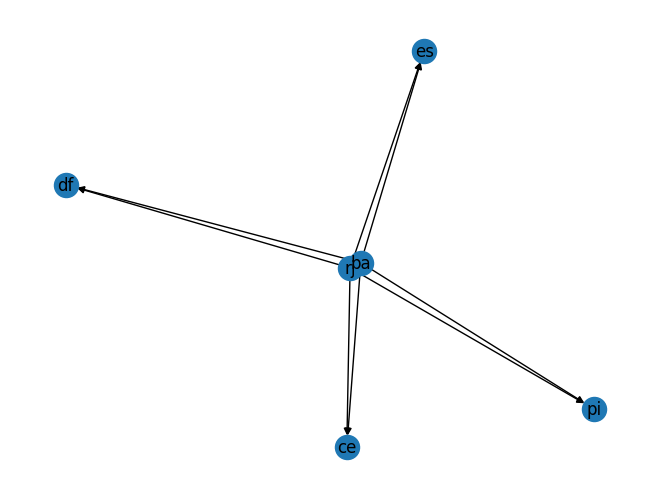

In [9]:
plot_edges(rtt)

### Summary
A partir dessa analise inicial podemos ver que nas duas medições temos apenas 2 clientes (ba, rj) enviando requisições para 4 servidores distintos (es, pi, ce, df).

As medições ocorreram entre os dias 7 e 12 junho de 2024. 10.901 pontos para RTT e 159.030 pontos para Bitrate.
Há 15 vezes mais medições de bitrate do que RTT.

**Bitrate** - taxa de transferência de dados em bits por segundo (bps)  
**RTT(Round-trip-time)** - tempo de ida e volta medido em milisegundos (ms) entre um cliente e um servidor.



## Calculate mean bitrate

Nos criamos a coluna `edge` para representar um par de conexão client-servidor único. Para cada edge em um mesmo timestamp há 15 medições individuais.

Nos gráficos abaixo exibimos o bitrate para todos os edges medidos ao longo de uma hora, e depois para o edge 'rj-pi' no intervalo de 15 minutos.

<Axes: xlabel='timestamp', ylabel='bitrate'>

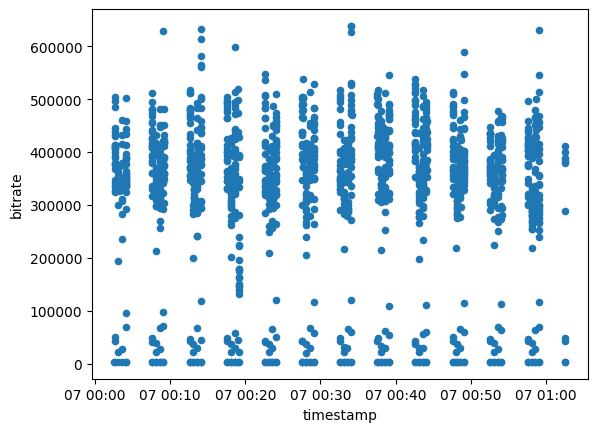

In [10]:
filter_interval(
    df = bitrate,
    minutes = 60
).plot.scatter(x='timestamp', y='bitrate')

<Axes: xlabel='timestamp', ylabel='bitrate'>

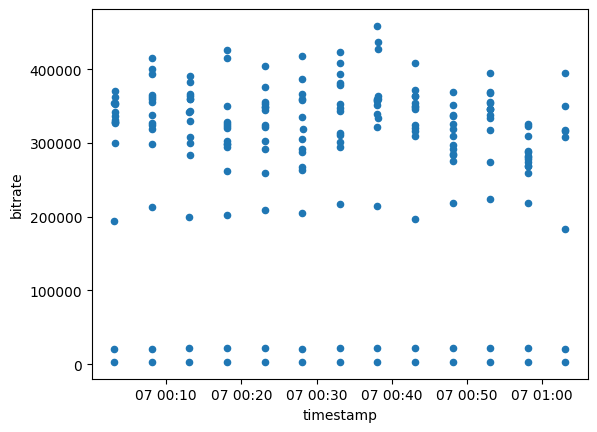

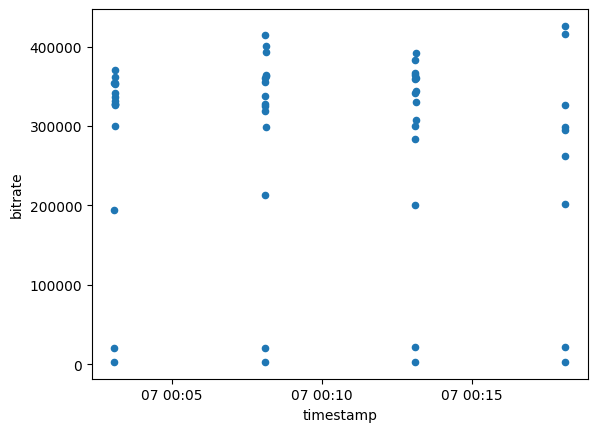

In [11]:
def filter_by_edge(df, edge: str) -> pd.DataFrame:
    return df.loc[df['edge'] == edge]

unique_edges = bitrate['edge'].unique()
dfs = {edge:filter_by_edge(bitrate, edge) for edge in unique_edges}

(
    filter_interval(df = dfs['rj-pi'], minutes = 60)
    .plot.scatter(x='timestamp', y='bitrate')
)

(
    filter_interval(df = dfs['rj-pi'], minutes = 15)
    .plot.scatter(x='timestamp', y='bitrate')
)

In [12]:
result = []
for edge in unique_edges:
    df3 = filter_by_edge(bitrate, edge)
    agg = group_by_timestamp(df3)
    for entrie in agg:
        entrie.update({'edge': edge})
    result.extend(agg)

bitrate_agg = pd.DataFrame(result)
bitrate_agg['mean'] = bitrate_agg['values'].apply(lambda x: np.mean(x))

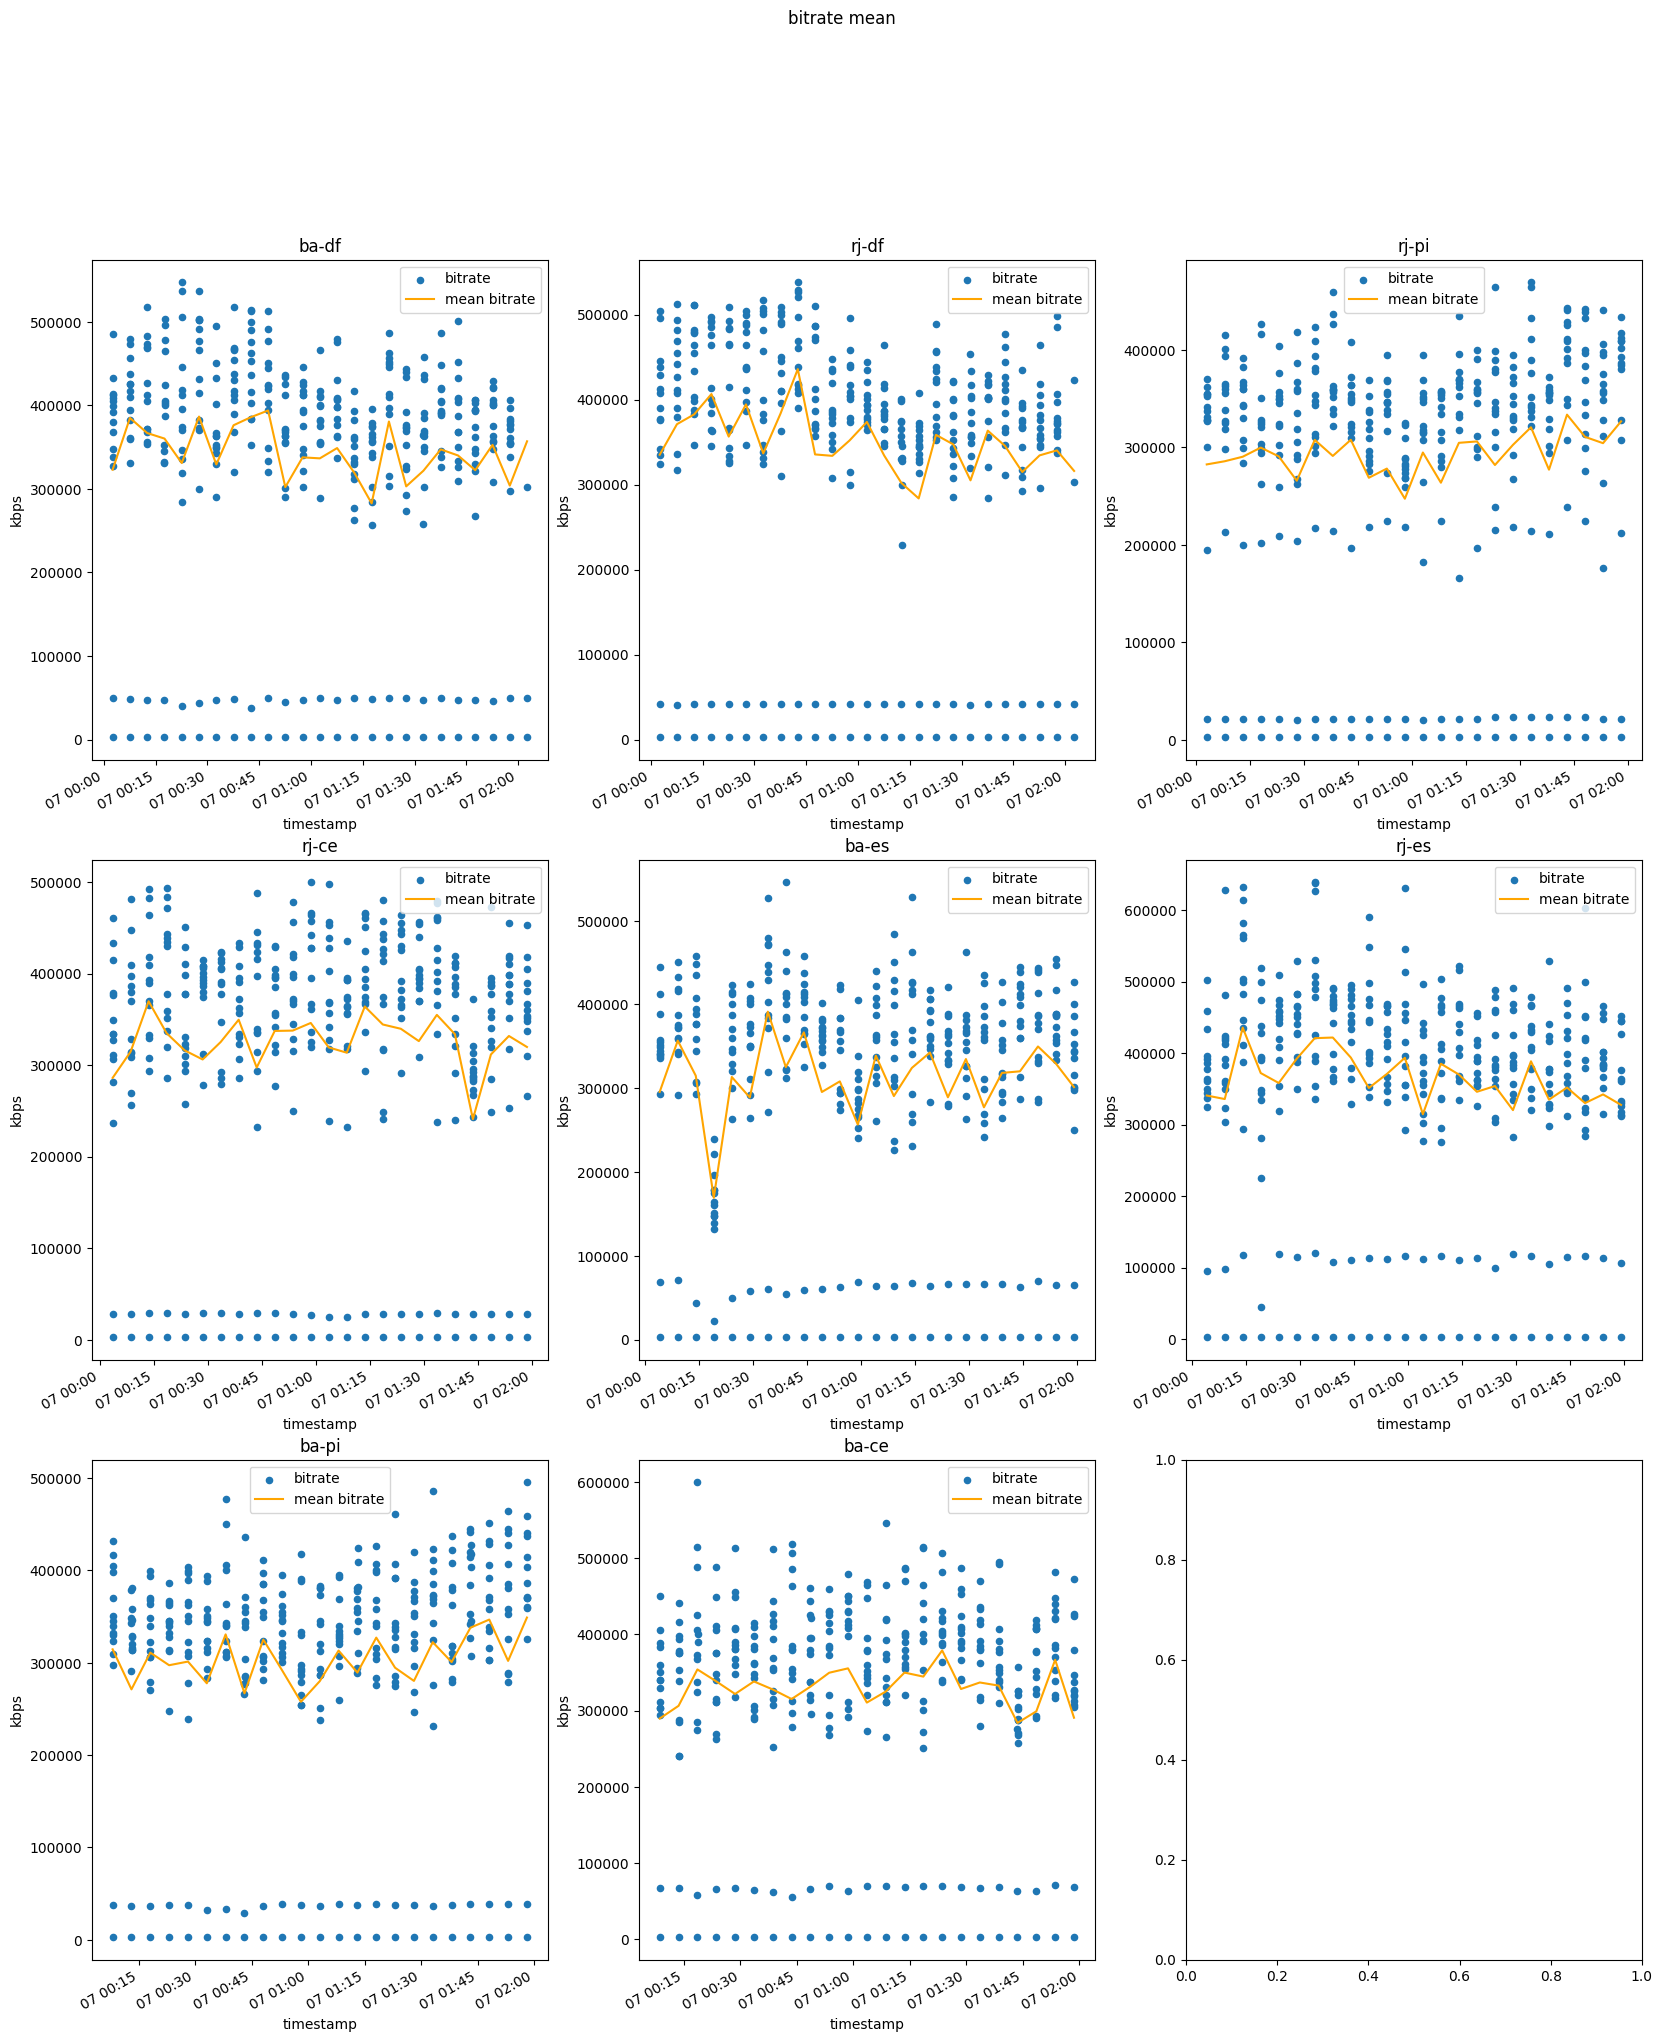

In [13]:
interval = 120

@with_subplot(by=unique_edges, title='bitrate mean')
def plot_bitrate_mean(ax, edge):
    df1 = filter_interval(bitrate, minutes=interval)
    df1 = filter_by_edge(df1, edge)

    df2 = filter_interval(bitrate_agg, minutes=interval)
    df2 = filter_by_edge(df2, edge)
    
    df1.plot(kind="scatter", x="timestamp",y="bitrate", label="bitrate", ax=ax)
    df2.plot(x="timestamp",y="mean", color="orange", label="mean bitrate", ax=ax)
    ax.set_xlabel("timestamp")
    ax.set_ylabel("kbps")
    ax.set_title(edge)


plot_bitrate_mean()

## Bitrate distribution

Observando os histogramas abaixo podemos visualizar o que parecer ser a soma de duas curvas normais, ou de pelo menos uma normal principal a direita e algum ruído a esquerda. 

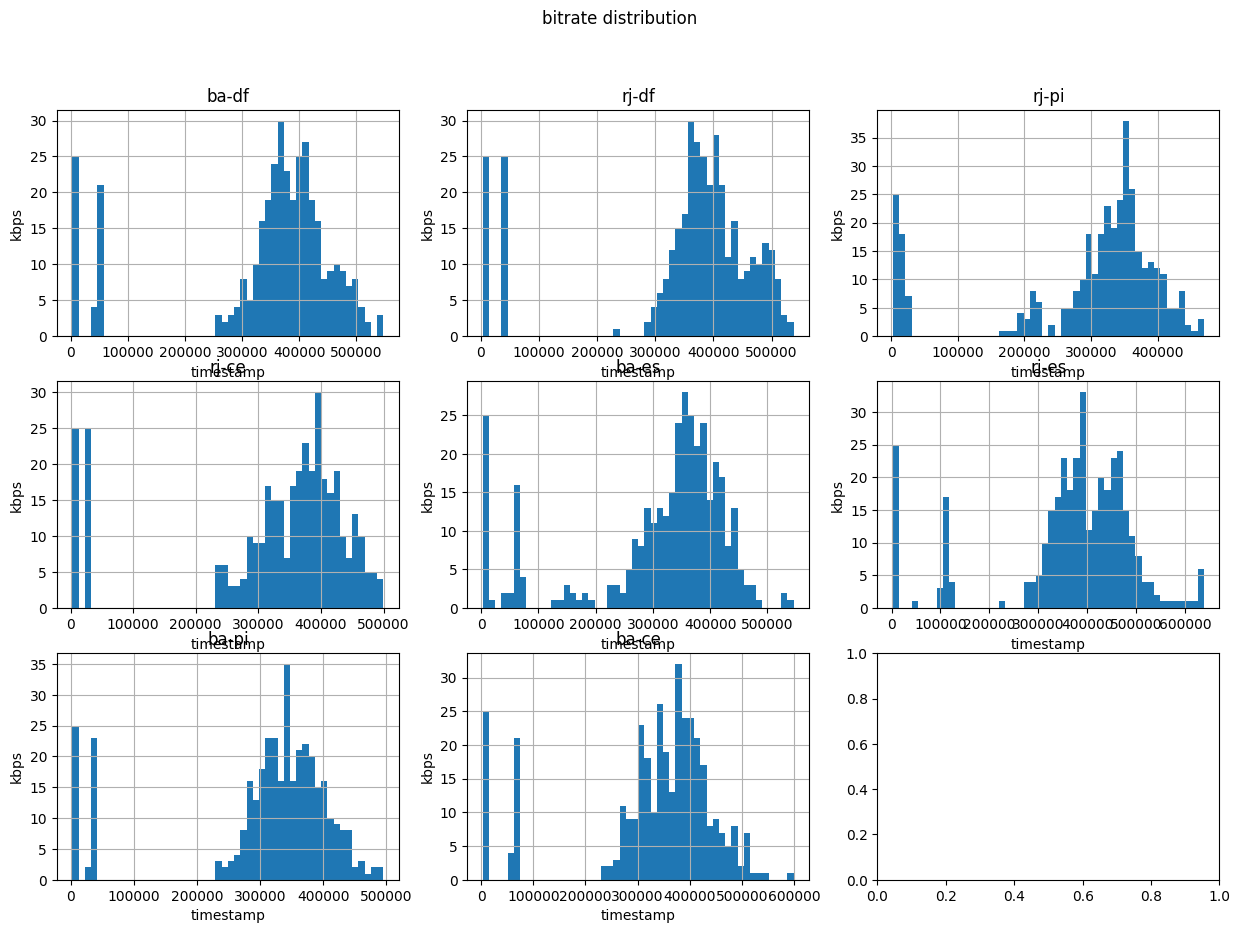

In [14]:
@with_subplot(by=unique_edges, figsize=(15,10), title='bitrate distribution')
def plot_bitrate_distribution(ax, edge):
    filter_interval(df = dfs[edge], minutes=interval)['bitrate'].hist(bins=50, ax = ax)
    ax.set_xlabel("timestamp")
    ax.set_ylabel("kbps")
    ax.set_title(edge)


plot_bitrate_distribution()

## RTT values

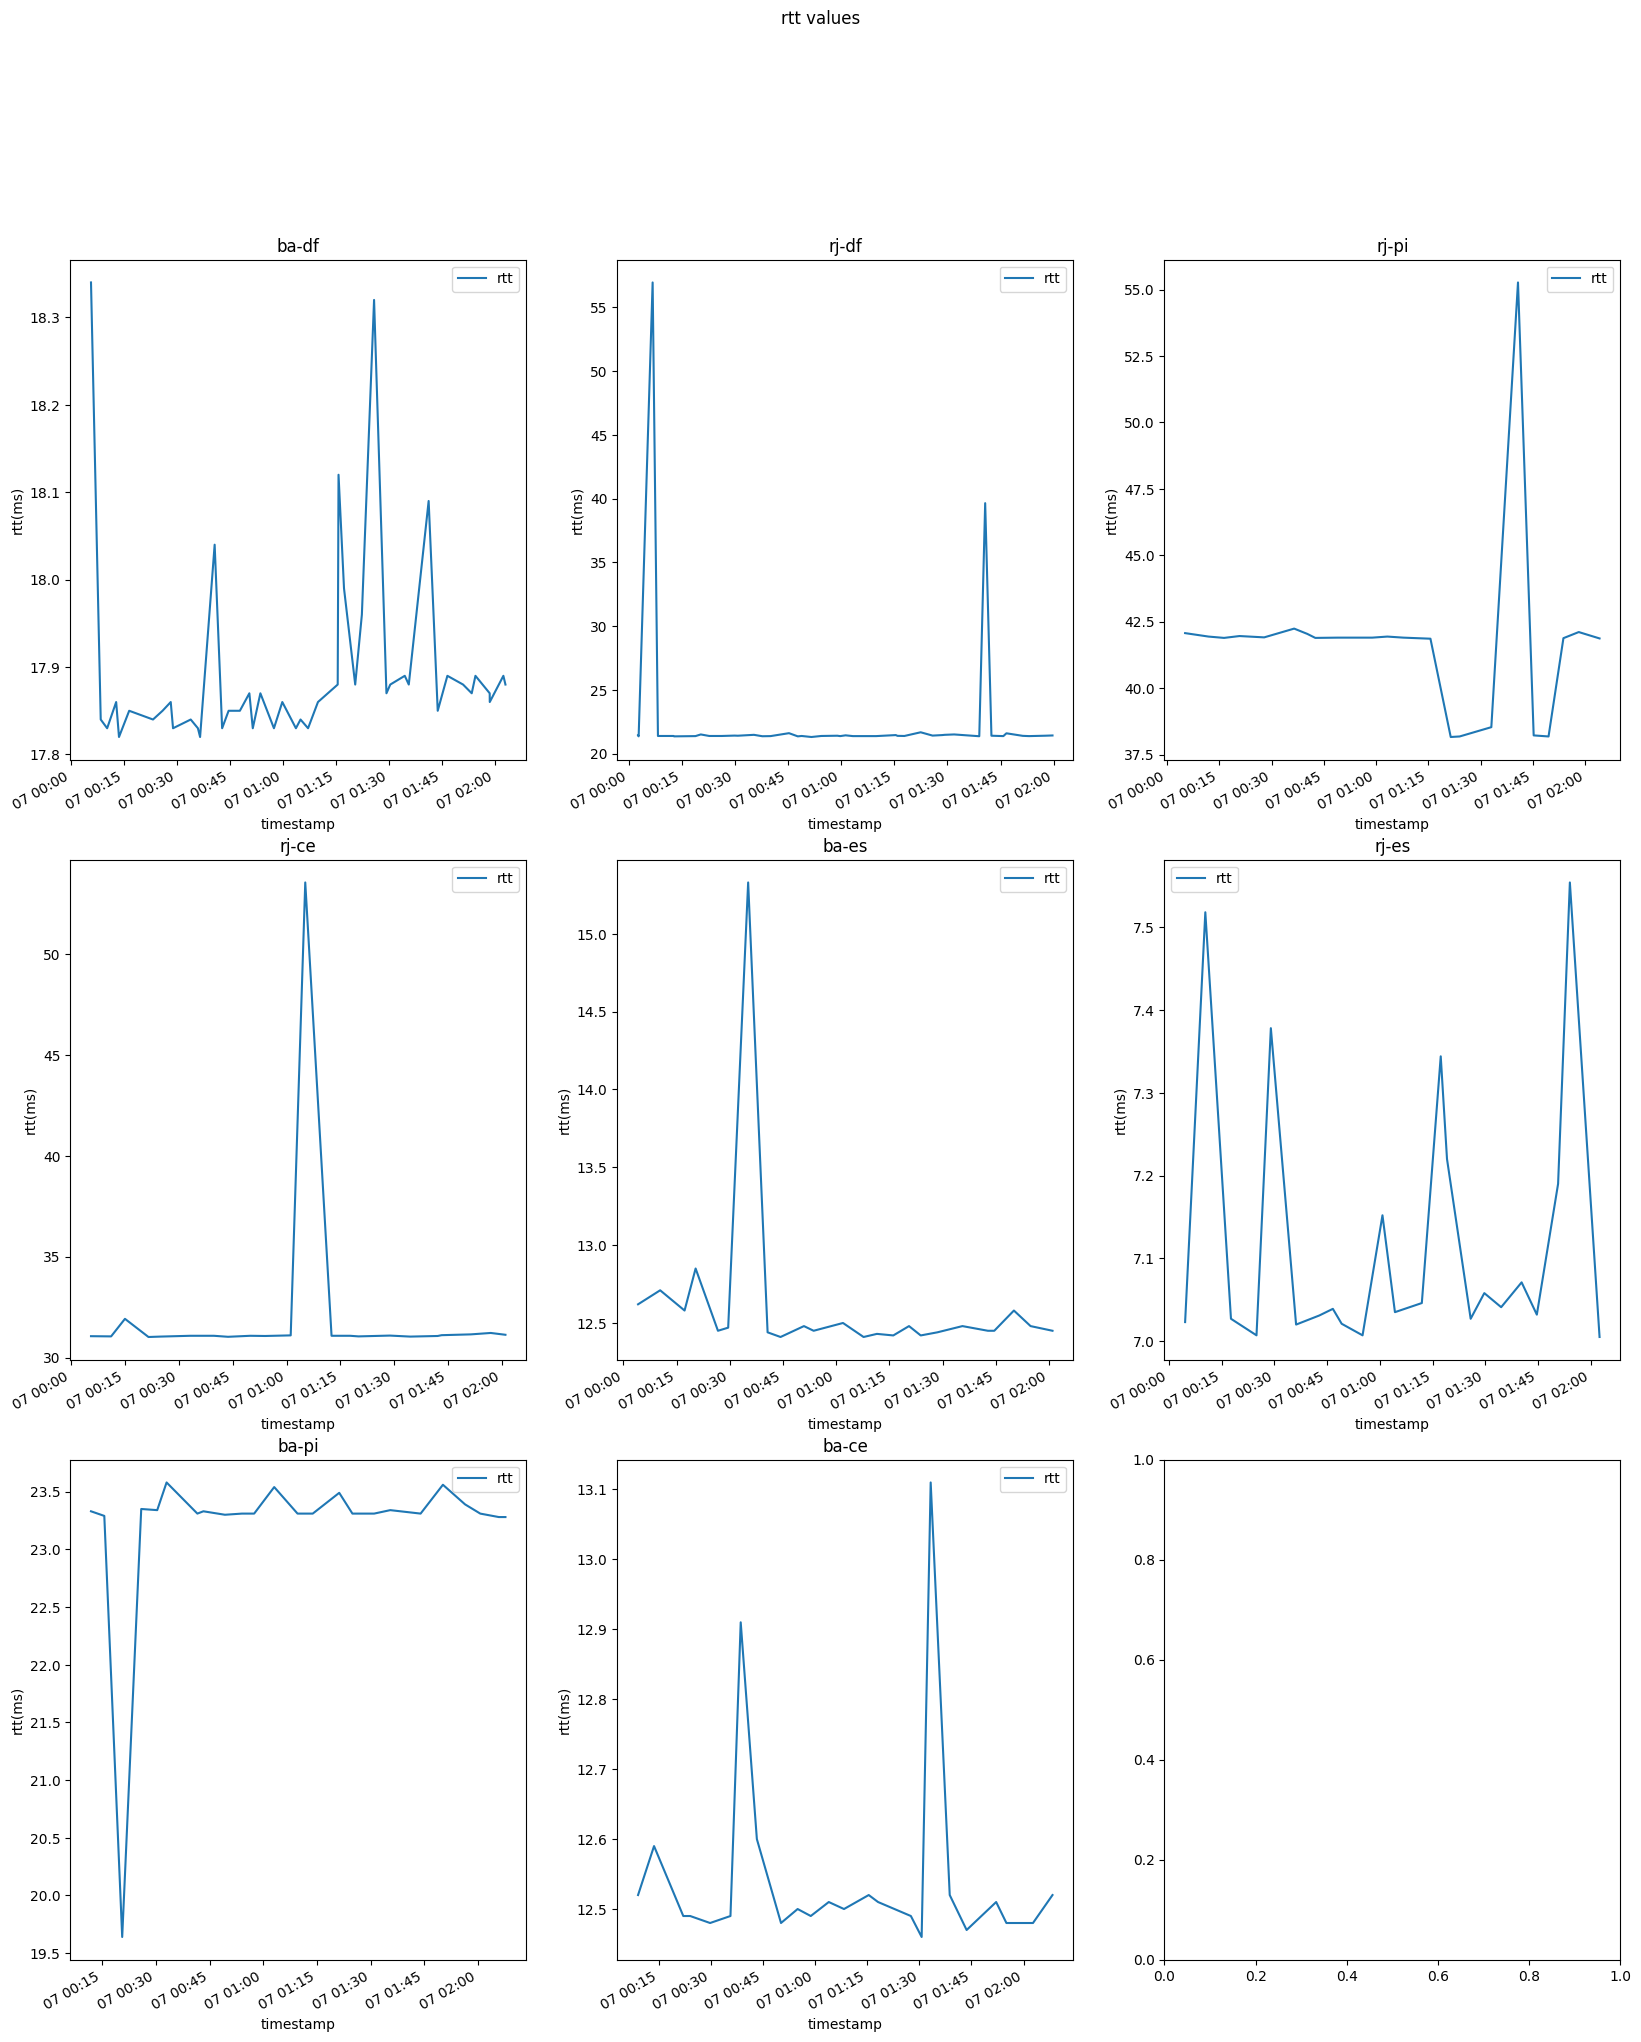

In [15]:
@with_subplot(by=unique_edges, title='rtt values')
def plot_rtt(ax, edge):
    df = filter_interval(filter_by_edge(rtt, edge),minutes=interval)
    df.plot(x='timestamp', y='rtt', ax=ax)
    ax.set_xlabel("timestamp")
    ax.set_ylabel("rtt(ms)")
    ax.set_title(edge)
plot_rtt()

### Merge bitrate and rtt

O bitrate normalizado (media de grupo de medições) apresenta um volume de dados semelhantes ao de RTT

In [16]:
bitrate_agg

,timestamp,values,edge,mean
0,2024-06-07 00:02:35,"[3000, 347367, 327273, 413041, 380017, 368659,...",ba-df,323058.250000
1,2024-06-07 00:07:36,"[417746, 456893, 425205, 48321, 479260, 330931...",ba-df,385048.800000
2,2024-06-07 00:12:36,"[354189, 469034, 404854, 372291, 3000, 47065, ...",ba-df,366947.733333
3,2024-06-07 00:17:36,"[332150, 330968, 352448, 47611, 3000, 503285, ...",ba-df,360345.733333
4,2024-06-07 00:22:36,"[336434, 370786, 40493, 3000, 284188, 346474, ...",ba-df,331049.733333
...,...,...,...,...
10589,2024-06-11 15:03:36,"[405213, 3000, 65927, 373515, 327813, 466367, ...",ba-ce,329547.933333
10590,2024-06-11 15:08:36,"[66888, 276422, 408225, 456560, 313376, 533002...",ba-ce,361486.000000
10591,2024-06-11 15:13:36,"[417558, 424656, 67129, 3000, 462842, 435128, ...",ba-ce,365202.066667
10592,2024-06-11 15:18:35,"[389325, 439009, 354171, 3000, 68310, 356890, ...",ba-ce,329374.666667


In [17]:
rtt

,client,server,timestamp,rtt,edge
timestamp,,,,,
2024-06-07 00:02:37,rj,df,2024-06-07 00:02:37,21.440,rj-df
2024-06-07 00:02:47,rj,df,2024-06-07 00:02:47,21.360,rj-df
2024-06-07 00:04:07,ba,es,2024-06-07 00:04:07,12.620,ba-es
2024-06-07 00:04:34,rj,es,2024-06-07 00:04:34,7.023,rj-es
2024-06-07 00:05:11,rj,pi,2024-06-07 00:05:11,42.070,rj-pi
...,...,...,...,...,...
2024-06-12 17:11:25,ba,pi,2024-06-12 17:11:25,23.330,ba-pi
2024-06-12 17:14:34,ba,ce,2024-06-12 17:14:34,12.450,ba-ce
2024-06-12 17:15:22,ba,pi,2024-06-12 17:15:22,23.320,ba-pi


In [18]:
rtt['edge'].value_counts()

edge
ba-ce    1492
rj-ce    1487
ba-pi    1361
ba-df    1347
rj-df    1339
rj-pi    1330
ba-es    1283
rj-es    1262
Name: count, dtype: int64

In [19]:
bitrate_agg['edge'].value_counts()

edge
rj-pi    1477
ba-pi    1459
ba-ce    1323
rj-ce    1310
ba-es    1286
rj-es    1285
ba-df    1231
rj-df    1223
Name: count, dtype: int64

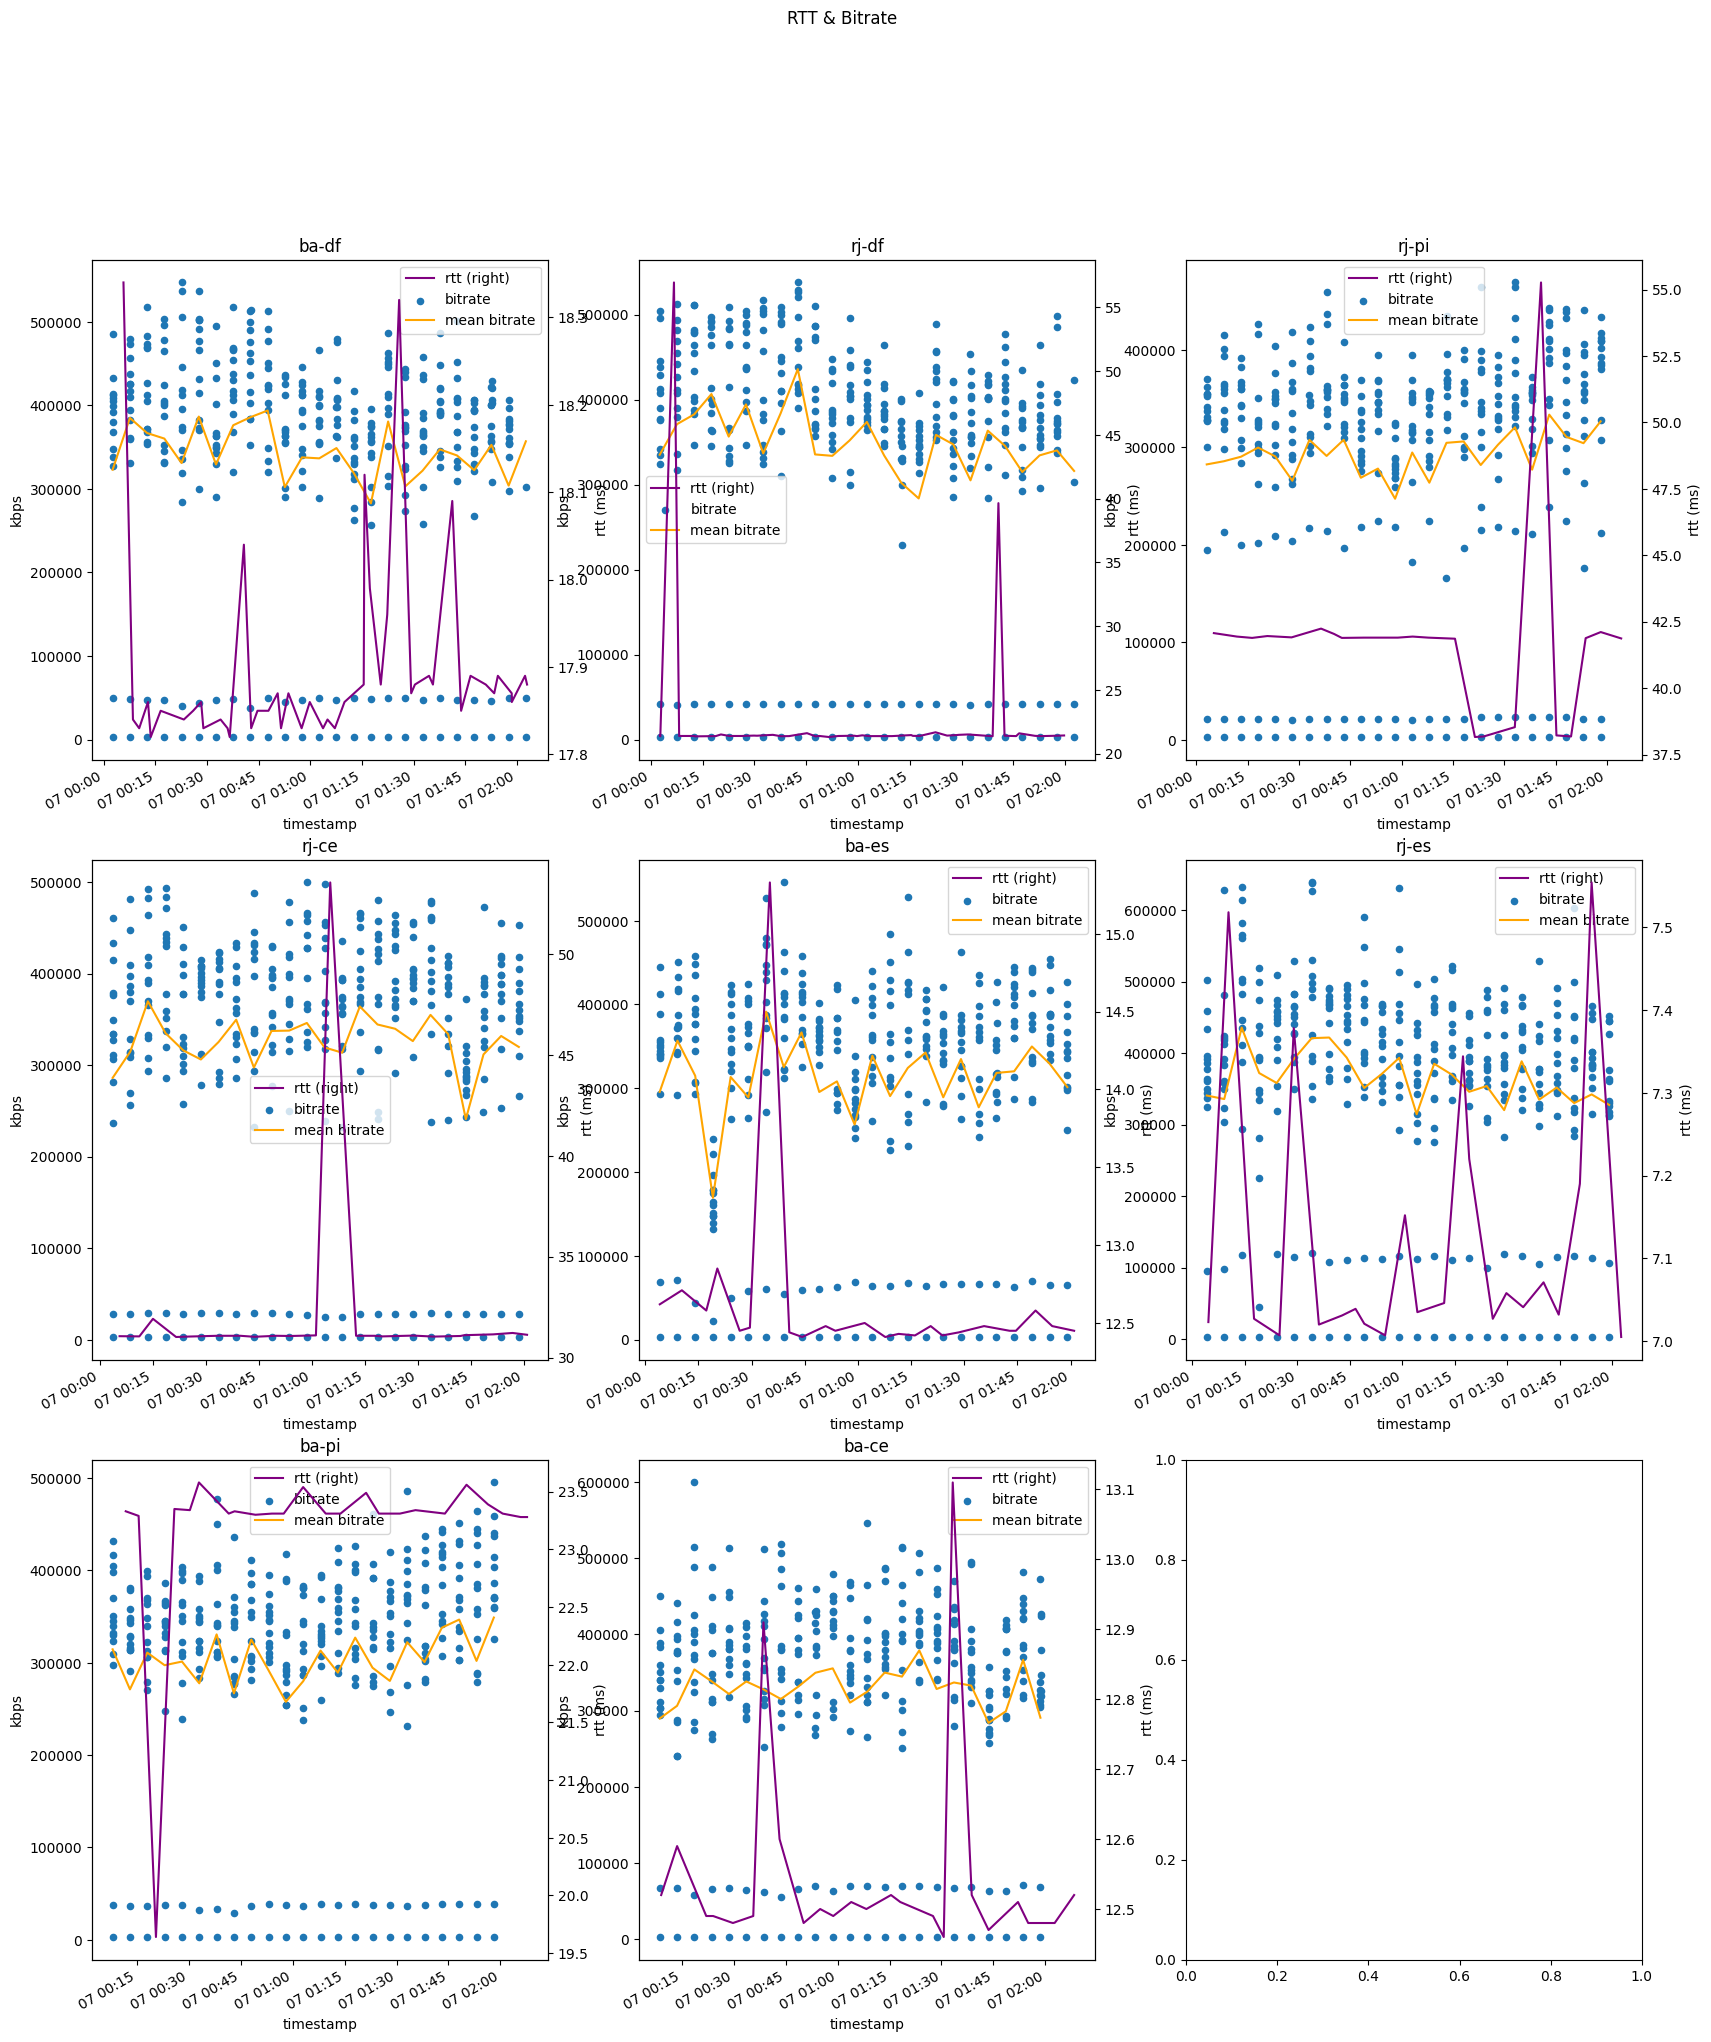

In [20]:
@with_subplot(by=unique_edges, title='RTT & Bitrate')
def plot_rtt_and_bitrate(ax, edge):
    df3 = filter_interval(filter_by_edge(rtt, edge),minutes=interval)
    ax2 = df3.plot(x='timestamp', y='rtt', ax=ax, secondary_y=True, color='purple')
    ax2.set_ylabel('rtt (ms)')
    

    df1 = filter_interval(bitrate, minutes=interval)
    df1 = filter_by_edge(df1, edge)
    df1.plot(kind="scatter", x="timestamp",y="bitrate", label="bitrate", ax=ax)

    df2 = filter_interval(bitrate_agg, minutes=interval)
    df2 = filter_by_edge(df2, edge)
    df2.plot(x="timestamp",y="mean", color="orange", label="mean bitrate", ax=ax)
    
    ax.set_xlabel("timestamp")
    ax.set_ylabel("kbps")
    ax.set_title(edge)


plot_rtt_and_bitrate()

In [21]:
rtt = rtt.reset_index(drop=True)
rtt

,client,server,timestamp,rtt,edge
0,rj,df,2024-06-07 00:02:37,21.440,rj-df
1,rj,df,2024-06-07 00:02:47,21.360,rj-df
2,ba,es,2024-06-07 00:04:07,12.620,ba-es
3,rj,es,2024-06-07 00:04:34,7.023,rj-es
4,rj,pi,2024-06-07 00:05:11,42.070,rj-pi
...,...,...,...,...,...
10896,ba,pi,2024-06-12 17:11:25,23.330,ba-pi
10897,ba,ce,2024-06-12 17:14:34,12.450,ba-ce
10898,ba,pi,2024-06-12 17:15:22,23.320,ba-pi
10899,ba,pi,2024-06-12 17:18:34,23.270,ba-pi


In [22]:
bitrate_agg = bitrate_agg.reset_index(drop=True)
bitrate_agg

,timestamp,values,edge,mean
0,2024-06-07 00:02:35,"[3000, 347367, 327273, 413041, 380017, 368659,...",ba-df,323058.250000
1,2024-06-07 00:07:36,"[417746, 456893, 425205, 48321, 479260, 330931...",ba-df,385048.800000
2,2024-06-07 00:12:36,"[354189, 469034, 404854, 372291, 3000, 47065, ...",ba-df,366947.733333
3,2024-06-07 00:17:36,"[332150, 330968, 352448, 47611, 3000, 503285, ...",ba-df,360345.733333
4,2024-06-07 00:22:36,"[336434, 370786, 40493, 3000, 284188, 346474, ...",ba-df,331049.733333
...,...,...,...,...
10589,2024-06-11 15:03:36,"[405213, 3000, 65927, 373515, 327813, 466367, ...",ba-ce,329547.933333
10590,2024-06-11 15:08:36,"[66888, 276422, 408225, 456560, 313376, 533002...",ba-ce,361486.000000
10591,2024-06-11 15:13:36,"[417558, 424656, 67129, 3000, 462842, 435128, ...",ba-ce,365202.066667
10592,2024-06-11 15:18:35,"[389325, 439009, 354171, 3000, 68310, 356890, ...",ba-ce,329374.666667


NOTE: agrupar os dois datasets pelo mesmo timestamp reduz muito os dados

In [23]:
left_columns = ['edge','mean','timestamp']
right_columns = ['edge','rtt','timestamp']
pd.merge(bitrate_agg[left_columns], rtt[right_columns], on=['timestamp','edge'])

,edge,mean,timestamp,rtt
0,ba-df,285816.466667,2024-06-07 04:42:35,18.460
1,ba-df,375126.600000,2024-06-08 02:02:35,17.890
2,ba-df,355986.000000,2024-06-09 06:37:35,17.900
3,ba-df,342659.000000,2024-06-09 18:42:36,18.040
4,rj-df,309222.066667,2024-06-07 05:32:35,31.400
5,rj-df,298106.066667,2024-06-07 05:42:36,31.260
6,rj-df,336284.066667,2024-06-07 21:47:35,31.260
7,rj-df,327664.000000,2024-06-09 17:12:36,22.030
8,rj-df,333822.066667,2024-06-10 15:37:36,19.460
9,rj-pi,301380.800000,2024-06-10 19:08:06,38.250


The idea is to populate the missing values in dataframe A with the mean of the two closest in the dataframe B


In [24]:
def calculate_value(tx, left, right):
    v_1 = left['rtt']
    v_2 = right['rtt']
    t_1 = left['timestamp']
    t_2 = right['timestamp']

    slope = ( v_2-v_1 )(t_2-t_1)
    y = v_1 + slope * (tx-t_1)
    return y

In [26]:
unique_edges

array(['ba-df', 'rj-df', 'rj-pi', 'rj-ce', 'ba-es', 'rj-es', 'ba-pi',
       'ba-ce'], dtype=object)

In [33]:


def merge_by_edge(serie_a, serie_b) -> list[dict]:
    # cursor a will be the index of values in serie A
    # cursor b will be the index of values in serie B

    result = []
    last_b = 0
    for a in range(len(serie_a)):

        # edge case
        # the first point in the B serie is to the righ of A serie
        #
        # B -----x-------
        # A --x------x---
        
        right = None
        left = None
        for b in range(last_b,len(serie_b)): # TODO: start from last left
            entrie_a = serie_a.iloc[a]
            
            time_a = serie_a.iloc[a]['timestamp']
            time_b = serie_a.iloc[b]['timestamp']
        
            if time_b == time_a:
                result.append({
                    'timestamp': time_a,
                    'edge': entrie_a['edge'],
                    'bitrate': entrie_a['mean'],
                    'rtt': serie_b.iloc[b]['rtt'],
                })
                last_b = b
                break # increment a

            if time_b < time_a:
                left = b

            if time_b > time_a:
                right = b

                
            has_only_right = left is None and right is not None
            if has_only_right:
                last_b = b
                break # increment a

            has_left_and_right = left is not None and right is not None
            if has_left_and_right:
                result.append({
                    'timestamp': time_a,
                    'edge': entrie_a['edge'],
                    'bitrate': entrie_a['mean'],
                    'rtt': calculate_value(time_a, serie_b.iloc[left], serie_b.iloc[right])
                })
                last_b = b
                break
        
    return result


result = []
for edge in unique_edges:
    result.extend(merge_by_edge(
        serie_a = filter_by_edge(bitrate_agg, edge),
        serie_b = filter_by_edge(rtt, edge)
    ))

a-b = 0-0
a-b = 1-0
a-b = 1-1
a-b = 2-1
a-b = 2-2
a-b = 3-2
a-b = 3-3
a-b = 4-3
a-b = 4-4
a-b = 5-4
a-b = 5-5
a-b = 6-5
a-b = 6-6
a-b = 7-6
a-b = 7-7
a-b = 8-7
a-b = 8-8
a-b = 9-8
a-b = 9-9
a-b = 10-9
a-b = 10-10
a-b = 11-10
a-b = 11-11
a-b = 12-11
a-b = 12-12
a-b = 13-12
a-b = 13-13
a-b = 14-13
a-b = 14-14
a-b = 15-14
a-b = 15-15
a-b = 16-15
a-b = 16-16
a-b = 17-16
a-b = 17-17
a-b = 18-17
a-b = 18-18
a-b = 19-18
a-b = 19-19
a-b = 20-19
a-b = 20-20
a-b = 21-20
a-b = 21-21
a-b = 22-21
a-b = 22-22
a-b = 23-22
a-b = 23-23
a-b = 24-23
a-b = 24-24
a-b = 25-24
a-b = 25-25
a-b = 26-25
a-b = 26-26
a-b = 27-26
a-b = 27-27
a-b = 28-27
a-b = 28-28
a-b = 29-28
a-b = 29-29
a-b = 30-29
a-b = 30-30
a-b = 31-30
a-b = 31-31
a-b = 32-31
a-b = 32-32
a-b = 33-32
a-b = 33-33
a-b = 34-33
a-b = 34-34
a-b = 35-34
a-b = 35-35
a-b = 36-35
a-b = 36-36
a-b = 37-36
a-b = 37-37
a-b = 38-37
a-b = 38-38
a-b = 39-38
a-b = 39-39
a-b = 40-39
a-b = 40-40
a-b = 41-40
a-b = 41-41
a-b = 42-41
a-b = 42-42
a-b = 43-42
a-b = 4

In [34]:
result_df = pd.DataFrame(result)
result_df

,timestamp,edge,bitrate,rtt
0,2024-06-07 00:02:35,ba-df,323058.250000,18.34
1,2024-06-07 00:07:36,ba-df,385048.800000,17.84
2,2024-06-07 00:12:36,ba-df,366947.733333,17.83
3,2024-06-07 00:17:36,ba-df,360345.733333,17.86
4,2024-06-07 00:22:36,ba-df,331049.733333,17.82
...,...,...,...,...
10318,2024-06-11 15:03:36,ba-ce,329547.933333,12.46
10319,2024-06-11 15:08:36,ba-ce,361486.000000,12.49
10320,2024-06-11 15:13:36,ba-ce,365202.066667,12.51
10321,2024-06-11 15:18:35,ba-ce,329374.666667,12.56


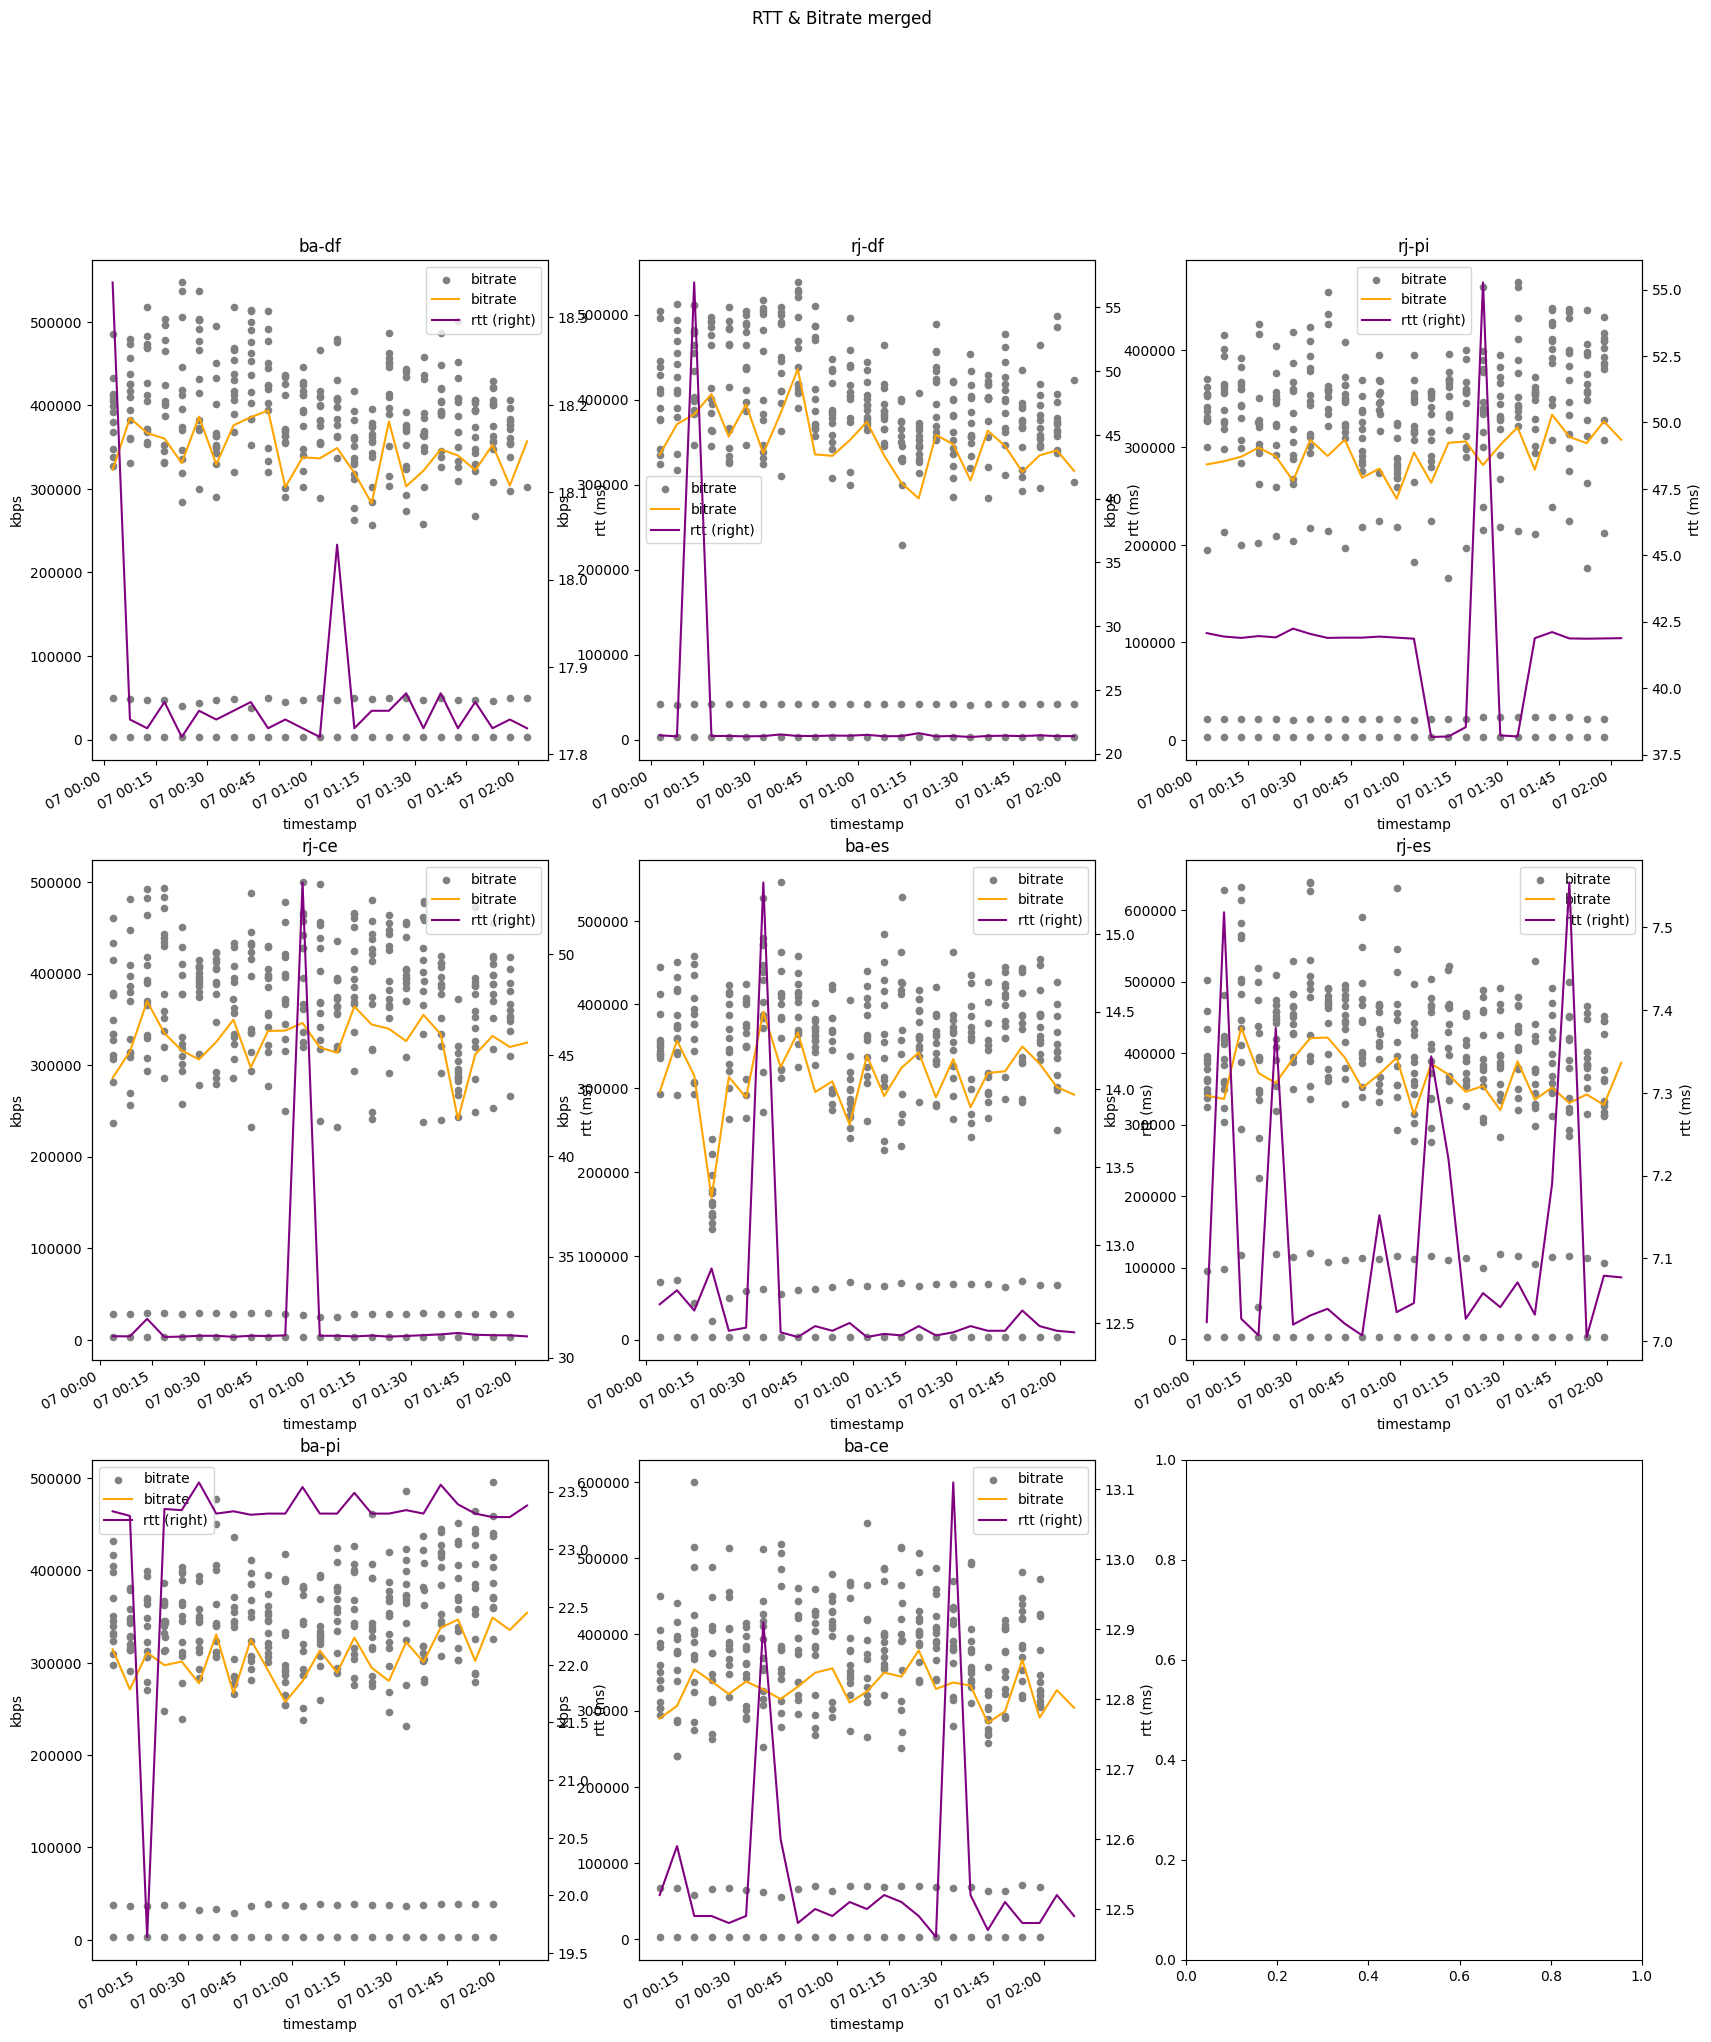

In [41]:
@with_subplot(by=unique_edges, title='RTT & Bitrate merged')
def plot_rtt_and_bitrate(ax, edge):
    df = filter_interval(
        filter_by_edge(
            result_df, edge
        ),
        minutes=interval
    )
    
    df1 = filter_interval(bitrate, minutes=interval)
    df1 = filter_by_edge(df1, edge)
    df1.plot(kind="scatter", x="timestamp",y="bitrate", label="bitrate", ax=ax, color='gray')

    df.plot(x='timestamp', y='bitrate', ax=ax, color='orange')
    ax2 = df.plot(x='timestamp', y='rtt', ax=ax, secondary_y=True, color='purple')
    
    ax2.set_ylabel('rtt (ms)')
    ax.set_xlabel("timestamp")
    ax.set_ylabel("kbps")
    ax.set_title(edge)


plot_rtt_and_bitrate()

In [42]:
result_df.to_csv('preprocessed_data.csv')